In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import norm, skew 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import math
from patsy import dmatrix

warnings.filterwarnings('ignore')

%matplotlib inline

import matplotlib as mpl
#plot 그릴 시, 데이터 개수가 많아 생기는 error 방지
mpl.rcParams['agg.path.chunksize'] = 10000

sns.set_style("whitegrid")

C:\Users\ledes\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print("shape of train data sets : ", train.shape)
print("shape of test data sets : ", test.shape)

shape of train data sets :  (1458644, 11)
shape of test data sets :  (625134, 9)


- columns에서 차이가 남을 확인

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


- 예측해야 하는 trip_duration과 이와 관련된 dropoff_datetime이 없음을 확인
- train 에서 dropoff datetime 은 사용안하기로 결정

In [3]:
#종속변수의 변화를 보기 위해 log1p를 취함.
log1p_y = np.log1p(train["trip_duration"]) 

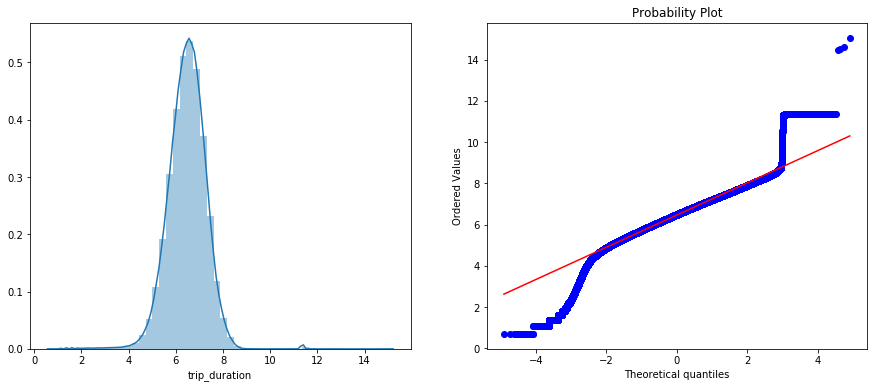

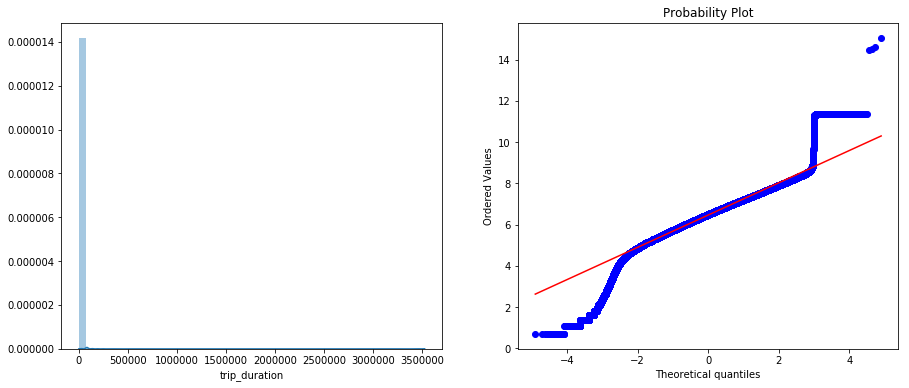

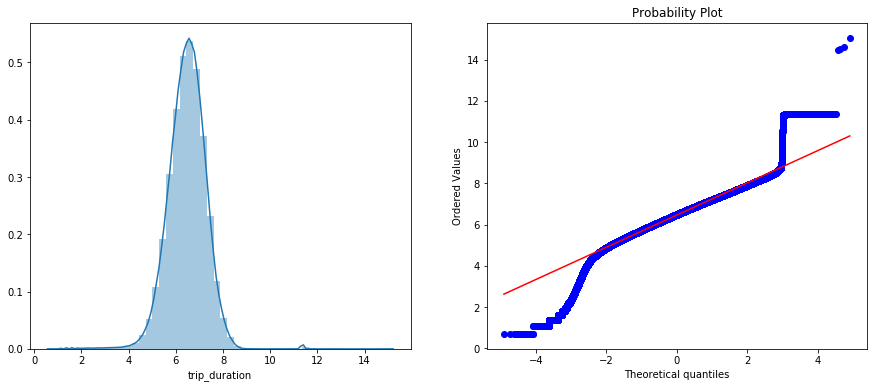

In [6]:
# 종속변수에 밑이 상용 로그인 경우
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
sns.distplot(log1p_y)

plt.subplot(1, 2, 2)
stats.probplot(log1p_y, plot = plt)

plt.show()

In [9]:
import math

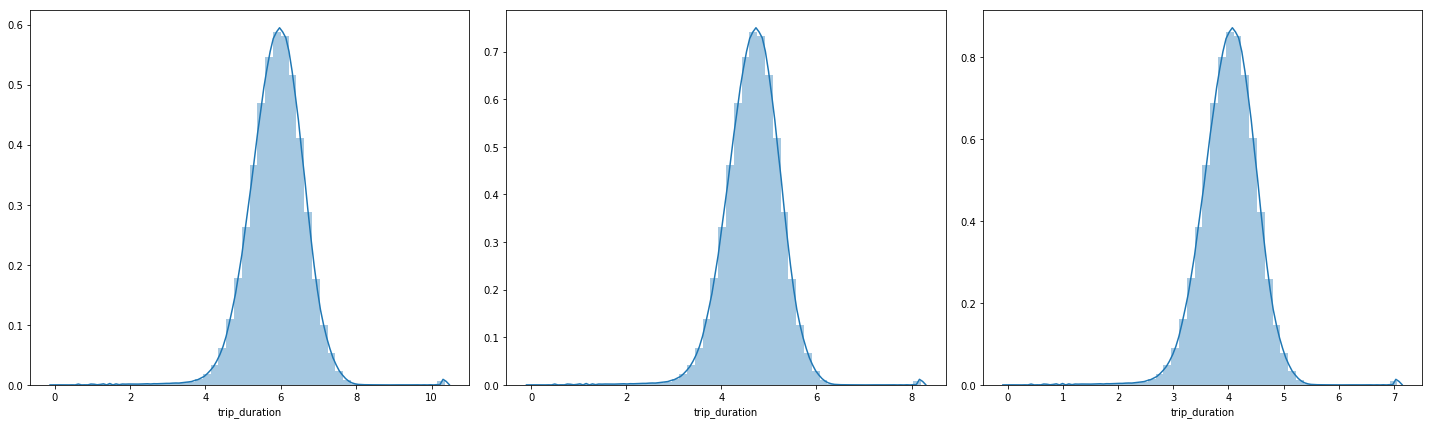

In [11]:
# 밑의 증가에 따른, 독립변수 그래프의 분포 변화
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.distplot(under_million.apply(lambda x: math.log(x, 3)))

plt.subplot(1, 3, 2)
sns.distplot(under_million.apply(lambda x: math.log(x, 4)))

plt.subplot(1, 3, 3)
sns.distplot(under_million.apply(lambda x: math.log(x, 5)))
plt.tight_layout()
plt.show()



- 종속변수의 아웃라이어 존재 확인
- 밑의 증가에 크게 영향을 받지 않음을 확인
- log1p(trip_duraition) 기준으로, 변수들과의 상관관계 확인

In [3]:
#log1p column새로 생성
train["log1p_y"] = np.log1p(train["trip_duration"])

### 각 독립변수와 종속변수의 상관관계 분석
- 데이터 개수로 scatter 류의 plot은 제외.

#### Vendor_id

In [13]:
train["vendor_id"].describe()

count    1.458644e+06
mean     1.534950e+00
std      4.987772e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: vendor_id, dtype: float64

- 데이터의 종류가 2가지임을 확인

In [12]:
vendor = train.pivot_table(index = "vendor_id", values = "log1p_y", aggfunc = "sum")
vendor

,log1p_y
vendor_id,
1,4.375407e+06
2,5.057613e+06


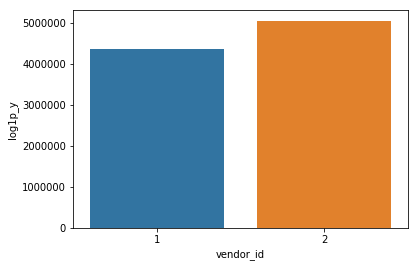

In [15]:
sns.barplot(x = vendor.index , y = "log1p_y", data = vendor)
plt.show()

- vendor_id 2에서 더 많은 탑승시간이 발생했음을 확인

#### Pickup_datetime

In [25]:
#날짜 데이터 분포 확인
datetime = pd.to_datetime(train["pickup_datetime"])
print("가장 처음 발생한 데이터", datetime.min())
print("가장 나중 발생한 데이터", datetime.max())


가장 처음 발생한 데이터 2016-01-01 00:00:17
가장 나중 발생한 데이터 2016-06-30 23:59:39


In [57]:
#월, 일,시, 요일별로 나눈 후 칼럼에 추가
train["month"] = pd.to_datetime(train["pickup_datetime"]).dt.month
train["day"] = pd.to_datetime(train["pickup_datetime"]).dt.day
train["hour"] = pd.to_datetime(train["pickup_datetime"]).dt.hour 
train["weekday"] = pd.to_datetime(train["pickup_datetime"]).dt.weekday

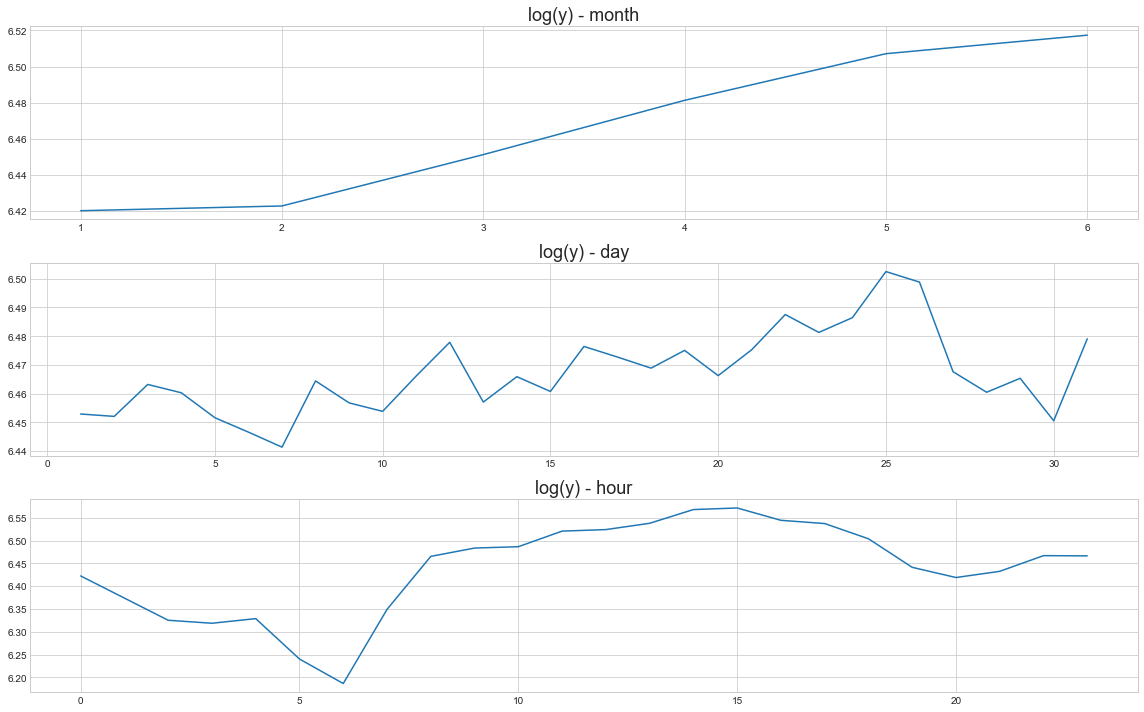

In [60]:
#월별, 일별, 시별 평균 탑승시간 
y_month = train.pivot_table(values = "log1p_y", index = "month")
y_day = train.pivot_table(values = "log1p_y", index = "day")
y_hour = train.pivot_table(values = "log1p_y", index = "hour")

plt.figure(figsize = (16, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(y_month)
plt.tick_params(labelsize=10)
plt.grid(True)
plt.title("log(y) - month", fontsize = 18)

ax2 = plt.subplot(3, 1, 2)
plt.plot(y_day)
plt.tick_params(labelsize=10)
plt.grid(True)
plt.title("log(y) - day", fontsize = 18)

ax3 = plt.subplot(3, 1, 3)
plt.plot(y_hour)
plt.tick_params(labelsize=10)
plt.grid(True)
plt.title("log(y) - hour", fontsize = 18)

plt.tight_layout()
plt.show()

 - 월별 기준 탑승시간 : 1월부터 6월까지 증가하는 경향
 - 일별 기준 탑승시간 : 25일을 기준으로 25일까지는 증가하다, 25일 이후로 감소
 - 시간별 기준 탑승시간 : 새벽 6시가 제일 낮고, 점점 증가하여 오후 3시가 제일 높음

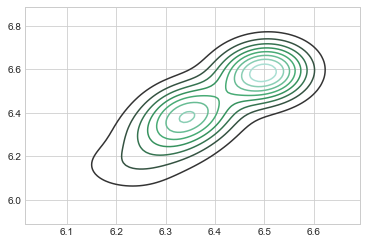

In [62]:
#요일별 탑승시간

y_hour_weekday = train.pivot_table(values = "log1p_y", index = "hour", columns = "weekday")

sns.plot(y_hour_weekday)